# Assignment 3

In this assignment, we will implement some well known interpretation methods: gradient based methods, Grad-CAM, and LRP. 
We have a vgg16 pre-trained model and some randomly sampled images from ImageNet validation set. We also have pre-defined functions for interpretation methods in yourAnswer.py file, but currently it returns dummy answers. 
What we have to do is to complete these skeleton codes and visualize them via this ipynb file.
Please follow the instructions, fill out the skeleton code, visualize your interpretation, and submit yourAnswer.py, module/linear.py, and executed Assignment3 file.

- A brief explanation for our attached files
    - Assignment3.ipynb
        - Instructions and visualization are given
    - data.pt
        - A subset of images from ImageNet validation set.
    - yourAnswer.py
        - A skelleton code for interpretations. 
    - utils.py
        - Utility functions are defined.
    - module (directory)
        - This directory contains modules to implement LRP. Since implementing every module is not easy for beginner, we only skeletonized the linear.py file.

- Submission
    - **STUDENT-ID_NAME-IN-ENGLISH.zip**
        - yourAnswer.py
        - linear.py
        - Assignment3.ipynb
            - Please clear out the results (**Kernel -> Restart & Clear Output**)
        - Assignment3.html
            - Please download it as .html file (**Kernel -> Restart & Run All // File -> Download as -> HTML(.html)**)
            - **The visualization of interpretation should be contained in .html file**
    
Note) For someone who are not familiar with pytorch, please refer the basic pytorch tutorial (10min): https://pytorch.org/tutorials/beginner/basics/intro.html

In [1]:
import torch
import torchvision

from utils import normalize, visualize_images, visualize_interpretations, resize

# 1. Predict and visualize

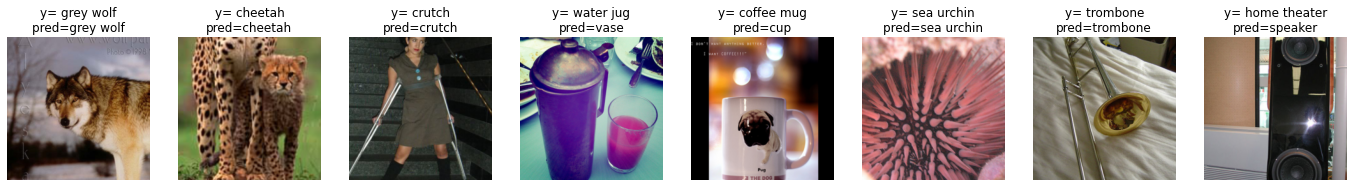

In [2]:
# load model
model = torchvision.models.vgg16(pretrained=True)

# load data and normalize
(x, y) = torch.load('data.pt') # x in [0, 1]
x = x[:8]
y = y[:8]
x_norm = normalize(x)
x_norm.requires_grad = True

# predict
pred = model(x_norm)
y_hat = torch.argmax(pred, dim=1)

# visualize
visualize_images(x, y, y_hat, row=1, col=8)

# 2. Interpretation

To interpret the behavior of model, we employ LRP, Grad-CAM, and the other four gradient based methods. 

In [3]:
from yourAnswer import simple_grad, integrated_grad, smooth_grad, input_x_grad, grad_cam

## Gradient based methods

Here, you should complete the skeleton functions in yourAnswer.py file. The followings are the equation for each interpretation methods.
- simple_grad : $h = \nabla_x f_c(x)$
- smooth_grad : $h = \sum_i \nabla_x f_c(x+n_i)$, where $n_i \sim N(0,\sigma^2)$
- input_x_grad : $h = x \odot \nabla_x f_c(x)$
- integrated_grad : $h = (x - x_b) \odot \sum_{i=0}^n \nabla_x f_c( \frac{i}{n} x + (1-\frac{i}{n}) x_b)$

where $f_c$ is a logit for class $c$.
For integrated grad, please set $x_b$ as zero vector

In [4]:
# base input for integrated gradient.
x_b = normalize(torch.zeros_like(x))

# Gradient based methods
h_simple_grad = simple_grad(model, x_norm, y)
h_smooth_grad = smooth_grad(model, x_norm, y, n_iter=10)
h_input_x_grad = input_x_grad(model, x_norm, y)
h_integrated_grad = integrated_grad(model, x_norm, y, x_b, n_iter=10)


## Grad-CAM

The skeleton function of Grad-CAM is also defined in yourAnswer.py file.  


\begin{equation}
    h=\operatorname{ReLU}\left(\sum_{k} \alpha_{k}^{c} \boldsymbol{A}_{k}\right) \quad \alpha_{k}^{c}=\frac{1}{Z} \sum_{i} \sum_{j} \frac{\partial f_{c}(\mathbf{x})}{\partial A_{i j k}}
\end{equation}


$\boldsymbol{A}$ is a feature map having multiple channels and $k$ is an index of them. $i$, $j$ are indices of width and height of feature maps respectively. First, you should obtain gradient of target class logit with respect to the feature map. Next, as shown in the above equation, you need to add each channel's element of  gradient map $\frac{\partial f_{c}(\mathbf{x})}{\partial A_{i j k}}$ to get $\alpha$. This $\alpha$ will be used to get weighted sum of feature map $\boldsymbol{A}$. After getting weighted sum of feature map, pass it through relu to get the final grad-cam result.

In [5]:
# Grad-CAM

h_grad_cam = grad_cam(model, x_norm, y)

## LRP

The functions of LRP is defined in module directory. Since it is hard to implement such LRP rule for the other layers, we only skeletonized the linear.py module.

### Important
In the lecture slide, you may see this equation.

\begin{equation}
R_i  =  \sum_j \frac{{x_i}{w_{ij}} }{ \epsilon + \sum_{i'} x_{i'} w_{i'j} } R_j
\end{equation}

In the typical implementation of LRP-epsilon, however, the $\epsilon$ should be differ for each element $j$. 

\begin{equation}
R_i  =  \sum_j \frac{{x_i}{w_{ij}} }{ \epsilon_{j} + \sum_{i'} x_{i'} w_{i'j} } R_j
\end{equation}

\begin{equation}
\epsilon_j = \epsilon \text{ s}\left(\sum_{i'} x_{i'} w_{i'j}\right) \\
\text{, where } s(x) = 1 \text{ if  } x\geq 0 \text{ else  } -1
\end{equation}
The usual choice is $\epsilon=1e-2$

In [6]:
from module.model_VGG16 import vgg16
# LRP-composite

model = vgg16(pretrained=True)
model.eval()
pred = model(x_norm)
R = torch.eye(1000, device=x.device, dtype=x.dtype)[y] * pred
h_lrp = model.lrp(R, lrp_mode="composite")

## Visualize your interpretation here.

To visualize the interpretation functions, we have to map $h \in \mathbb{R}^d$ into $\mathbb{R}^d \rightarrow \{0,1,...,255\}^d$ or $\mathbb{R}^d \rightarrow [0, 1]^d$. To achieve this, the frequently used technique on interpretation researches is define as follows,

$h \leftarrow (\frac{|h|}{max(|h|)}+1)/2$

We use 'sessmic' colormap.

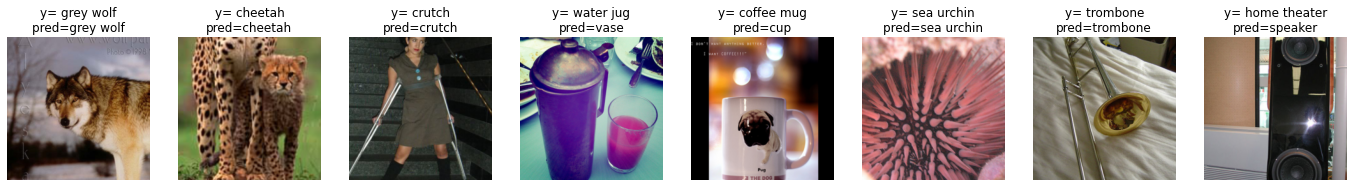

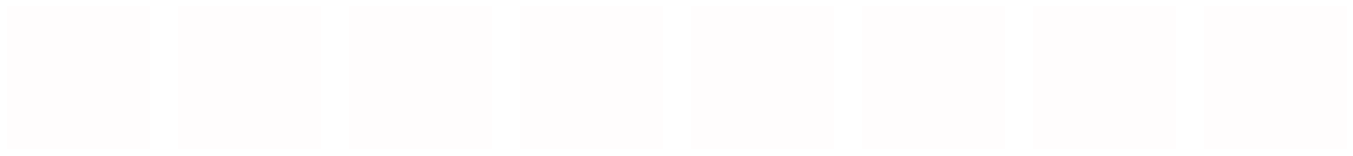

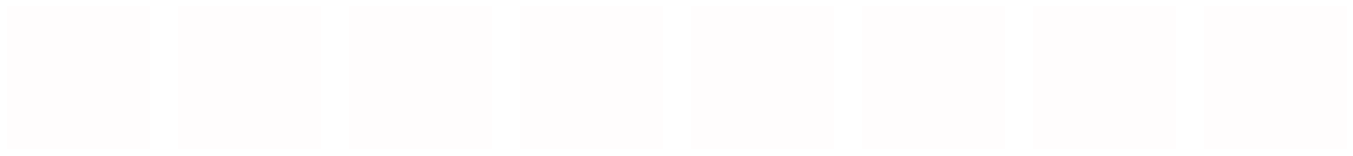

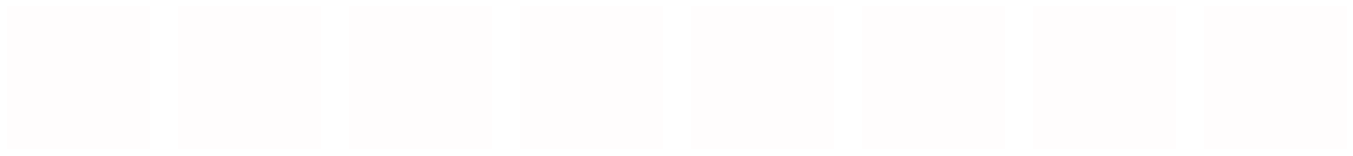

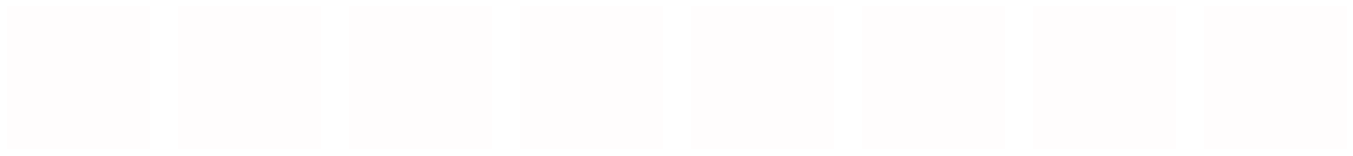

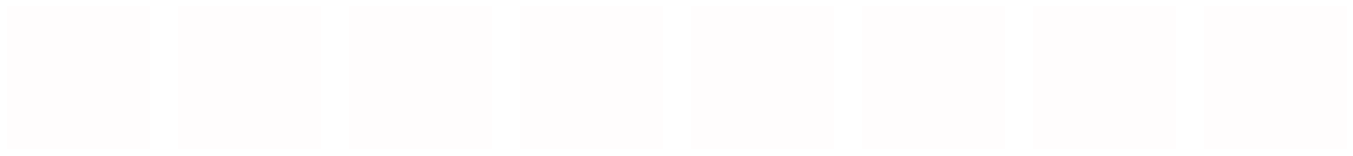

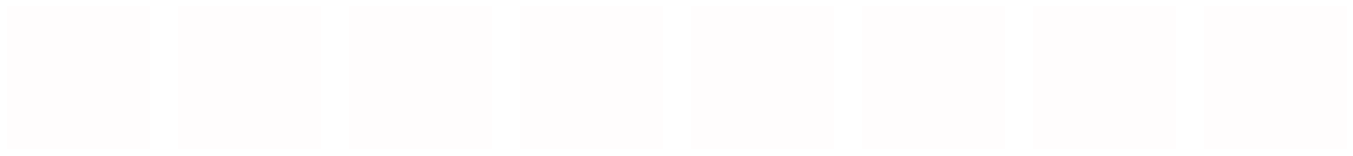

In [7]:
visualize_images(x, y, y_hat, row=1, col=8)
visualize_interpretations(h_simple_grad, row=1, col=8, absolute=True)
visualize_interpretations(h_smooth_grad, row=1, col=8, absolute=True)
visualize_interpretations(h_input_x_grad, row=1, col=8, absolute=True)
visualize_interpretations(h_integrated_grad, row=1, col=8, absolute=True)
visualize_interpretations(h_lrp.detach(), row=1, col=8, absolute=False)
visualize_interpretations(resize(h_grad_cam, 224, 224), row=1, col=8, absolute=True)